In [1]:
#### linear SVR ## baysian 
import pandas as pd
df = pd.read_csv(r"C:\\Users\\JellevanAs\\Documents\\Studie\\Thesis\\df-english.csv")


In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from ast import literal_eval



df["ada_embedding_eng"] = df["ada_embedding_eng"].apply(literal_eval).apply(np.array)

x = df["ada_embedding_eng"]
y = df['numerical_price']
###### deleting original dataframe for memory purpose ####
del df

# Explode the embedding arrays into separate rows
x = x.apply(pd.Series)
# First split: separate out a test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Now, sample 10000 instances from the remaining training set for hyperparameter tuning
x_train = x_train.sample(10000, random_state=42)
y_train = y_train.loc[x_train.index]



In [7]:
from sklearn.model_selection import KFold
from sklearn.svm import LinearSVR
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import optuna

def Objective_linear_svr(trial):
    # Parameters for LinearSVR
    C = trial.suggest_loguniform("C", 1e-3, 1e3)
    epsilon = trial.suggest_loguniform("epsilon", 1e-3, 1e1)
    tol = trial.suggest_loguniform("tol", 1e-5, 1e-1)
    loss = trial.suggest_categorical("loss", ['epsilon_insensitive', 'squared_epsilon_insensitive'])

    # Ensure compatible settings for dual and loss
    if loss == 'epsilon_insensitive':
        dual = True  # dual must be True for 'epsilon_insensitive'
    else:
        dual = trial.suggest_categorical("dual", [True, False])

    fit_intercept = trial.suggest_categorical("fit_intercept", [True, False])
    intercept_scaling = trial.suggest_uniform("intercept_scaling", 0.1, 10)
    max_iter = trial.suggest_int("max_iter", 1000, 10000)

    linear_svr_params = dict(C=C, epsilon=epsilon, tol=tol, loss=loss, 
                             fit_intercept=fit_intercept, intercept_scaling=intercept_scaling, 
                             dual=dual, max_iter=max_iter)

    clf_linear_svr = LinearSVR(**linear_svr_params, random_state=0)

    # StandardScaler for y
    scaler = StandardScaler()

    # KFold Cross-validation
    kf = KFold(n_splits=5)
    r2_scores = []

    for train_index, test_index in kf.split(x_train):
        X_train_fold, X_test_fold = x_train.iloc[train_index], x_train.iloc[test_index]
        y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

        # Scaling y_train
        y_train_scaled = scaler.fit_transform(y_train_fold.values.reshape(-1, 1))
        y_train_scaled = y_train_scaled.ravel()

        # Fitting the model
        clf_linear_svr.fit(X_train_fold, y_train_scaled)

        # Predicting and inverse transformation
        y_pred_scaled = clf_linear_svr.predict(X_test_fold)
        y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

        # R2 Score
        r2 = r2_score(y_test_fold, y_pred)
        r2_scores.append(r2)


    return float(np.mean(r2_scores))


In [4]:
study_svr = optuna.create_study(directions=['maximize'])
study_svr.optimize(Objective_linear_svr, n_trials=50)

[I 2024-01-06 13:36:51,540] A new study created in memory with name: no-name-9ba3de6c-ff13-4e4d-960b-72654c52eea0


C:\Users\JellevanAs\AppData\Local\Temp\ipykernel_5752\3605284942.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform("C", 1e-3, 1e3)
C:\Users\JellevanAs\AppData\Local\Temp\ipykernel_5752\3605284942.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  epsilon = trial.suggest_loguniform("epsilon", 1e-3, 1e1)
C:\Users\JellevanAs\AppData\Local\Temp\ipykernel_5752\3605284942.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  tol = trial.suggest_loguniform("tol", 1e-5, 1e-1)
C:\Users\Je

C:\Users\JellevanAs\AppData\Local\Temp\ipykernel_5752\1847014462.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study_svr)


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

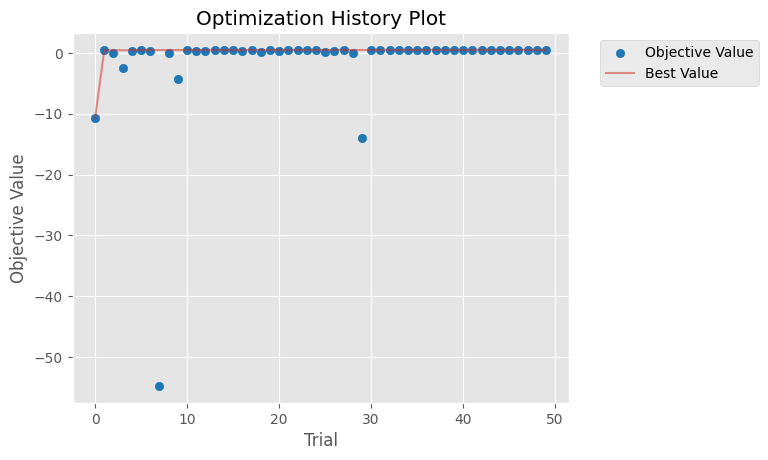

In [8]:
optuna.visualization.matplotlib.plot_optimization_history(study_svr)

C:\Users\JellevanAs\AppData\Local\Temp\ipykernel_5752\1495321963.py:4: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study_svr)
C:\Users\JellevanAs\AppData\Local\Temp\ipykernel_5752\1495321963.py:6: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna_matplotlib.plot_optimization_history(study_svr)


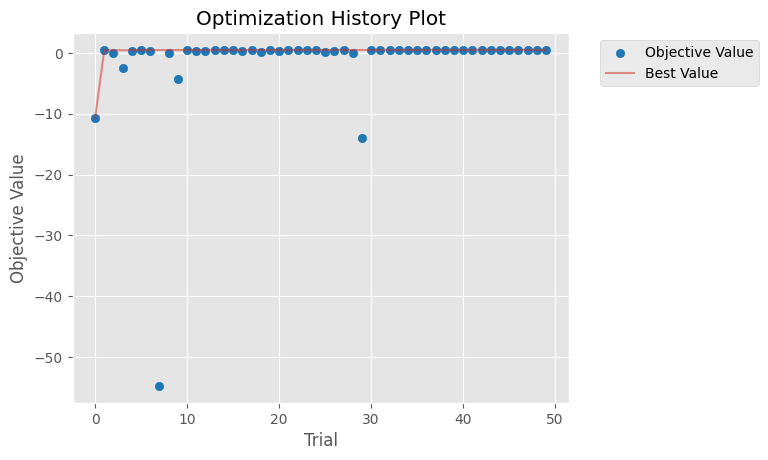

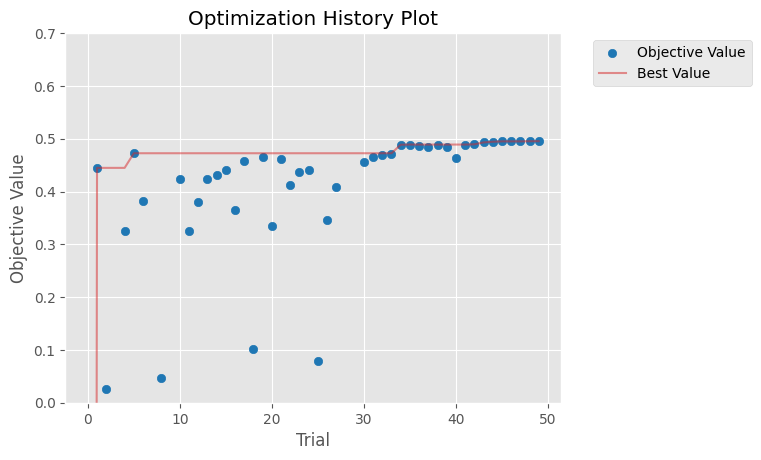

In [9]:
from optuna.visualization import matplotlib as optuna_matplotlib
import matplotlib.pyplot as plt
# Plot the optimization history in a different format
optuna.visualization.matplotlib.plot_optimization_history(study_svr)

optuna_matplotlib.plot_optimization_history(study_svr)

plt.ylim(0, 0.7)

plt.show()